In [1]:
def create_checkerboard(num_squares=2, square_size=1, margin=0, density=10000):
    # Total dimensions of the board
    total_size = num_squares * square_size
    # Initialize dataset
    data = []
    # Create checkerboard pattern
    for i in range(num_squares):
        for j in range(num_squares):
            # Determine the fill status (either filled or empty)
            if (i + j) % 2 == 0:  # Fill every other square
                # Center coordinates of the square
                center_x = i * square_size + square_size / 2 + margin
                center_y = j * square_size + square_size / 2 + margin
                # Generate points around the center
                points_x = center_x + (np.random.rand(density) - 0.5) * square_size
                points_y = center_y + (np.random.rand(density) - 0.5) * square_size
                # Add points to data
                data.append(np.stack([points_x, points_y], axis=1))
    # Convert list of arrays into a single numpy array
    data = np.concatenate(data, axis=0)
    return data - num_squares/2.0

In [2]:
import torch
import numpy as np
import math

# Parameters
T = 200  # Number of time steps
N = 40000  # Number of paths
dt = 1.0 / T
theta = lambda t: np.log(1.01 * (1-t) + 10 * t)
mu = lambda t: 0
sigma = lambda t: math.sqrt(2*theta(t))

# Time vector
time_vector = torch.linspace(0, 1, T)

# Initial distribution: mixture of Gaussians
mix_weights = torch.tensor([0.5, 0.5])
mean1 = torch.tensor([1.5, 1.5])
mean2 = torch.tensor([-1.5, -1.5])
cov1 = torch.eye(2) * 0.5
cov2 = torch.eye(2) * 0.3

def create_checkerboard(num_squares=2, square_size=1, margin=0, density=10000):
    # Total dimensions of the board
    total_size = num_squares * square_size
    # Initialize dataset
    data = []
    # Create checkerboard pattern
    for i in range(num_squares):
        for j in range(num_squares):
            # Determine the fill status (either filled or empty)
            if (i + j) % 2 == 0:  # Fill every other square
                # Center coordinates of the square
                center_x = i * square_size + square_size / 2 + margin
                center_y = j * square_size + square_size / 2 + margin
                # Generate points around the center
                points_x = center_x + (np.random.rand(density) - 0.5) * square_size
                points_y = center_y + (np.random.rand(density) - 0.5) * square_size
                # Add points to data
                data.append(np.stack([points_x, points_y], axis=1))
    # Convert list of arrays into a single numpy array
    data = np.concatenate(data, axis=0)
    return data - num_squares/2.0

initial_samples = torch.from_numpy(create_checkerboard(num_squares=3, density=10000))

# Shuffle initial samples
N = initial_samples.shape[0]
perm = torch.randperm(N)
initial_samples = initial_samples[perm]

# Simulate the 2D OU process
brownian_motion = torch.zeros(N, T, 2)
bm_increments = torch.zeros(N, T, 2)
dynamics = torch.zeros(N, T, 2)
dynamics[:, 0, :] = initial_samples
params = torch.zeros(N, T, 2)
params[:, 0, 0] = theta(0)
params[:, 0, 1] = sigma(0)

for i in range(1, T):
    bm_increments[:, i] = torch.sqrt(torch.tensor(dt)) * torch.randn(N, 2)
    brownian_motion[:, i] = brownian_motion[:, i-1] + bm_increments[:, i-1]
    dynamics[:, i] = dynamics[:, i-1] + theta((i-1)/T) * (mu((i-1)/T) - dynamics[:, i-1]) * dt + sigma((i-1)/T) * bm_increments[:, i-1]
    params[:, i, 0] = theta((i-1)/T)
    params[:, i, 1] = sigma((i-1)/T)

# Preparing the tensors
time_tensor = time_vector.repeat(N, 1)
process_tensor = torch.cat([time_tensor[:, :, None], brownian_motion, bm_increments], dim=2)#.permute(1, 0, 2)
dynamics_tensor = dynamics#.permute(1, 0, 2)

# Extract the end time dynamics (at time T-1, which corresponds to time 1 in the simulation)
end_time_dynamics = dynamics[:, -1, :].unsqueeze(1).repeat(1, T, 1)

# Append the end time dynamics to the process tensor
process_tensor = torch.cat([process_tensor, end_time_dynamics, params], dim=2)

print("Updated process tensor shape:", process_tensor.shape)
print("Dynamics tensor shape:", dynamics_tensor.shape)

Updated process tensor shape: torch.Size([50000, 200, 9])
Dynamics tensor shape: torch.Size([50000, 200, 2])


In [3]:
'''import torch
import numpy as np
import math

# Parameters
T = 200  # Number of time steps
N_paths = 40000  # Number of paths
dt = 1.0 / T
theta = lambda t: np.log(1.01 * (1-t) + 10 * t)
mu = lambda t: 0
sigma = lambda t: math.sqrt(2 * theta(t))
K = 128  # Number of terms in the K–K–L expansion
data_dim = 2

# Time vector
time_vector = torch.linspace(0, 1, T)

# Function to generate Brownian paths using the K–K–L expansion
def generate_brownian_motion(N, T, K):
    dt = 1.0/T
    t = np.linspace(0, 1, T)
    Z = np.random.randn(N, K, data_dim)  # Independent standard normals for each term
    #brownian_paths = np.zeros((N, T))
    bm_increments = np.zeros((N, T, data_dim))
    for k in range(1, K + 1):
        #eigenvalue = math.sqrt(2) / ((k - 0.5) * math.pi)
        #sin_component = np.sin((k - 0.5) * math.pi * t)
        cos_component = np.cos((k - 0.5) * math.pi * t)
        coeifs = math.sqrt(2) 
        #brownian_paths += eigenvalue * sin_component * Z[:, k - 1].reshape(N, 1)
        #print(Z[:, k - 1].shape, cos_component.shape, ( Z[:, k - 1].reshape(N, 1) * cos_component).shape)
        bm_increments += dt * coeifs * Z[:, k-1, :].reshape((N, 1, data_dim)) * cos_component.reshape((1, -1, 1))
    #return torch.tensor(brownian_paths, dtype=torch.float32)
    return torch.tensor(bm_increments, dtype=torch.float32)

# Generate initial checkerboard samples as initial points
initial_samples = torch.from_numpy(create_checkerboard(num_squares=3, density=10000))

# Shuffle initial samples
N = initial_samples.shape[0]
perm = torch.randperm(N)
initial_samples = initial_samples[perm]

# Simulate the 2D OU process
bm_increments = generate_brownian_motion(N, T, K) #.unsqueeze(-1).repeat(1, 1, 2)  # Repeat for 2D
brownian_motion = torch.cumsum(bm_increments, dim=1)
dynamics = torch.zeros(N, T, 2)
dynamics[:, 0, :] = initial_samples
params = torch.zeros(N, T, 2)
params[:, 0, 0] = theta(0)
params[:, 0, 1] = sigma(0)

for i in range(1, T):
    dynamics[:, i] = dynamics[:, i-1] + theta(i/T) * (mu(i/T) - dynamics[:, i-1]) * dt + sigma(i/T) * bm_increments[:, i]
    params[:, i, 0] = theta(i/T)
    params[:, i, 1] = sigma(i/T)

# Preparing the tensors
time_tensor = time_vector.repeat(N, 1)
process_tensor = torch.cat([time_tensor[:, :, None], brownian_motion, bm_increments], dim=2)
dynamics_tensor = dynamics

# Extract and append the end time dynamics to the process tensor
end_time_dynamics = dynamics[:, -1, :].unsqueeze(1).repeat(1, T, 1)
process_tensor = torch.cat([process_tensor, end_time_dynamics, params], dim=2)

print("Updated process tensor shape:", process_tensor.shape)
print("Dynamics tensor shape:", dynamics_tensor.shape)'''
''

''

[0, 12, 25, 50, 199]


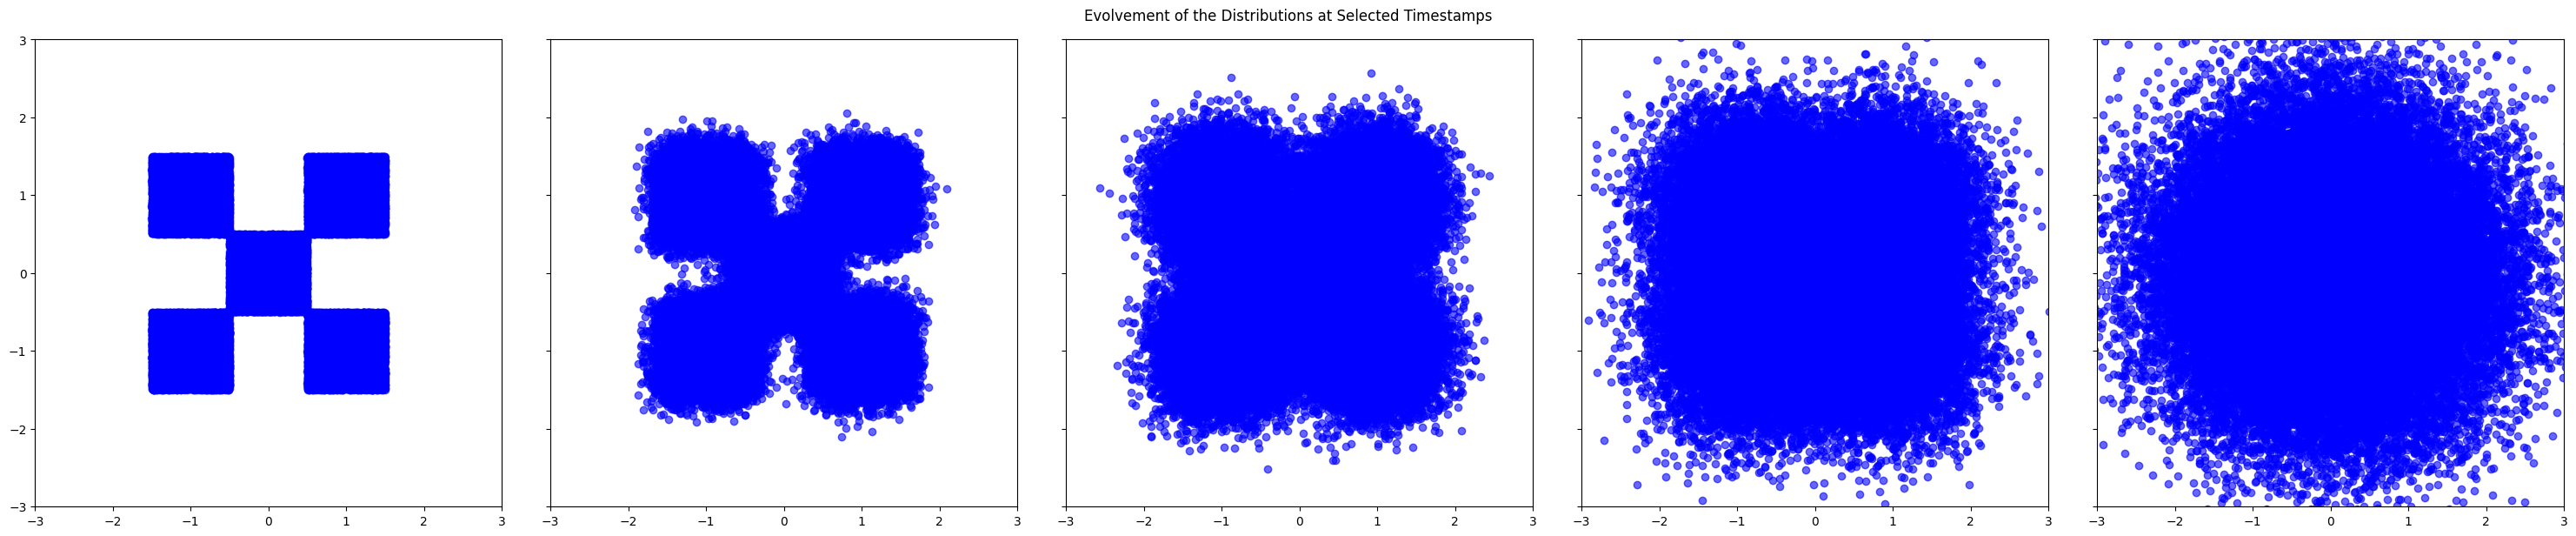

In [4]:
import matplotlib.pyplot as plt

# Select timestamps to visualize
selected_timestamps = [0, T//16, T//8, T//4, T-1]
selected_times = [time_vector[t].item() for t in selected_timestamps]

# Extract the data for the selected timestamps
subset_data = dynamics_tensor[:, selected_timestamps, :]
print(selected_timestamps)
# Plotting the distributions
fig, axs = plt.subplots(1, len(selected_timestamps), figsize=(30, 6), sharey=True)

for i, (ax, t, time) in enumerate(zip(axs, selected_timestamps, selected_times)):
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.scatter(subset_data[:, i, 0].numpy(), subset_data[:, i, 1].numpy(), color='blue', alpha=0.6)
    ax.set_aspect('equal')  # This makes the x and y axes of equal lengths

plt.suptitle('Evolvement of the Distributions at Selected Timestamps')
plt.tight_layout()
plt.show()


In [5]:
import torch
from torch.utils.data import Dataset, DataLoader

class OUDataset(Dataset):
    def __init__(self, process_tensor, dynamics_tensor):
        """
        Initializes the dataset with the process and dynamics tensors.
        :param process_tensor: Tensor containing timestamps, Brownian motion, and increments.
        :param dynamics_tensor: Tensor containing the dynamics of the OU process.
        """
        self.process_tensor = process_tensor
        self.dynamics_tensor = dynamics_tensor

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return self.process_tensor.shape[0]

    def __getitem__(self, idx):
        """
        Retrieves the process and dynamics tensors for the given index.
        :param idx: Index of the desired sample.
        :return: A dictionary with keys 'x' and 'y'.
        """
        x = self.process_tensor[idx]
        y = self.dynamics_tensor[idx]
        return {'x': x.permute(1, 0), 'y': y.permute(1, 0)}

# Assuming the previously defined process_tensor and dynamics_tensor are available
dataset = OUDataset(process_tensor, dynamics_tensor)

In [6]:
from torch.utils.data import random_split

# Total number of samples in the dataset
total_samples = len(dataset)

# Define the size of the train and test sets
train_size = int(0.8 * total_samples)
test_size = total_samples - train_size

# Perform the train-test split
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Creating DataLoaders for both train and test sets
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2**15, shuffle=False)

# Quick check of DataLoader outputs
for data in train_loader:
    print("Train sample 'x' shape:", data['x'].shape)
    print("Train sample 'y' shape:", data['y'].shape)
    break  # Showing only the first batch from the training set
'''
for data in test_loader:
    print("Test sample 'x' shape:", data['x'].shape)
    print("Test sample 'y' shape:", data['y'].shape)
    break  # Showing only the first batch from the testing set'''

Train sample 'x' shape: torch.Size([256, 9, 200])
Train sample 'y' shape: torch.Size([256, 2, 200])


'\nfor data in test_loader:\n    print("Test sample \'x\' shape:", data[\'x\'].shape)\n    print("Test sample \'y\' shape:", data[\'y\'].shape)\n    break  # Showing only the first batch from the testing set'

In [7]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import TFNO
from neuralop import Trainer
from neuralop.datasets import load_darcy_flow_small
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

device = 'cuda'

# We create a tensorized FNO model

model = TFNO(
    n_modes=(12, ),
    in_channels=9,
    out_channels=2,
    hidden_channels=64,
    projection_channels=128,
    n_layers=16,
    factorization='tucker',
    rank=1.0  # TODO: what does this parameter mean? set it to 1 seems problematic but set it to 1.0 seems good
)
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


# %%
#Create the optimizer
optimizer = torch.optim.Adam(model.parameters(), 
                                lr=1e-3, 
                                weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)


# %%
# Creating the losses
l2loss = LpLoss(d=2, p=2)
h1loss = H1Loss(d=2)

train_loss = h1loss
eval_losses={'h1': h1loss, 'l2': l2loss}


# %%


print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


# %% 
# Create the trainer
trainer = Trainer(model=model,
                  n_epochs=200,
                  device=device,
                  data_processor=None, #data_processor,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)


# %%
# Actually train the model on our small Darcy-Flow dataset

trainer.train(train_loader=train_loader,
              test_loaders={50: test_loader, 100: test_loader},
              optimizer=optimizer,
              scheduler=scheduler, 
              regularizer=False, 
              training_loss=train_loss,
              eval_losses=eval_losses)


Our model has 978946 parameters.

### MODEL ###
 TFNO(
  (fno_blocks): FNOBlocks(
    (convs): SpectralConv(
      (weight): ModuleList(
        (0-15): 16 x ComplexTuckerTensor(shape=(64, 64, 7), rank=(58, 58, 6))
      )
    )
    (fno_skips): ModuleList(
      (0-15): 16 x Flattened1dConv(
        (conv): Conv1d(64, 64, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv1d(9, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(256, 64, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (1): Conv1d(128, 2, kernel_size=(1,), stride=(1,))
    )
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.002
    lr: 0.002
    maximize: False
    weight_decay: 1e-05
)

### SCHE

{'100_h1': 0.024005569458007813, '100_l2': 0.025513238525390624}

In [8]:
import torch
import matplotlib.pyplot as plt

# Assuming the test_loader is correctly set up and model is trained
# Fetch a batch of data from test_loader
test_batch = next(iter(test_loader))
x_test = test_batch['x']
y_test = test_batch['y']

# Move the test batch to the device
x_test = x_test.to(device)
y_test = y_test.to(device)

# Predict using the trained model
with torch.no_grad():
    model.eval()
    predictions = model(x_test)
print(predictions.shape)

torch.Size([10000, 2, 200])


In [9]:
predictions[:, :, 0].mean(dim=0), y_test[:, :, 0].mean(dim=0)

(tensor([ 0.0106, -0.0229], device='cuda:0'),
 tensor([ 0.0123, -0.0149], device='cuda:0'))

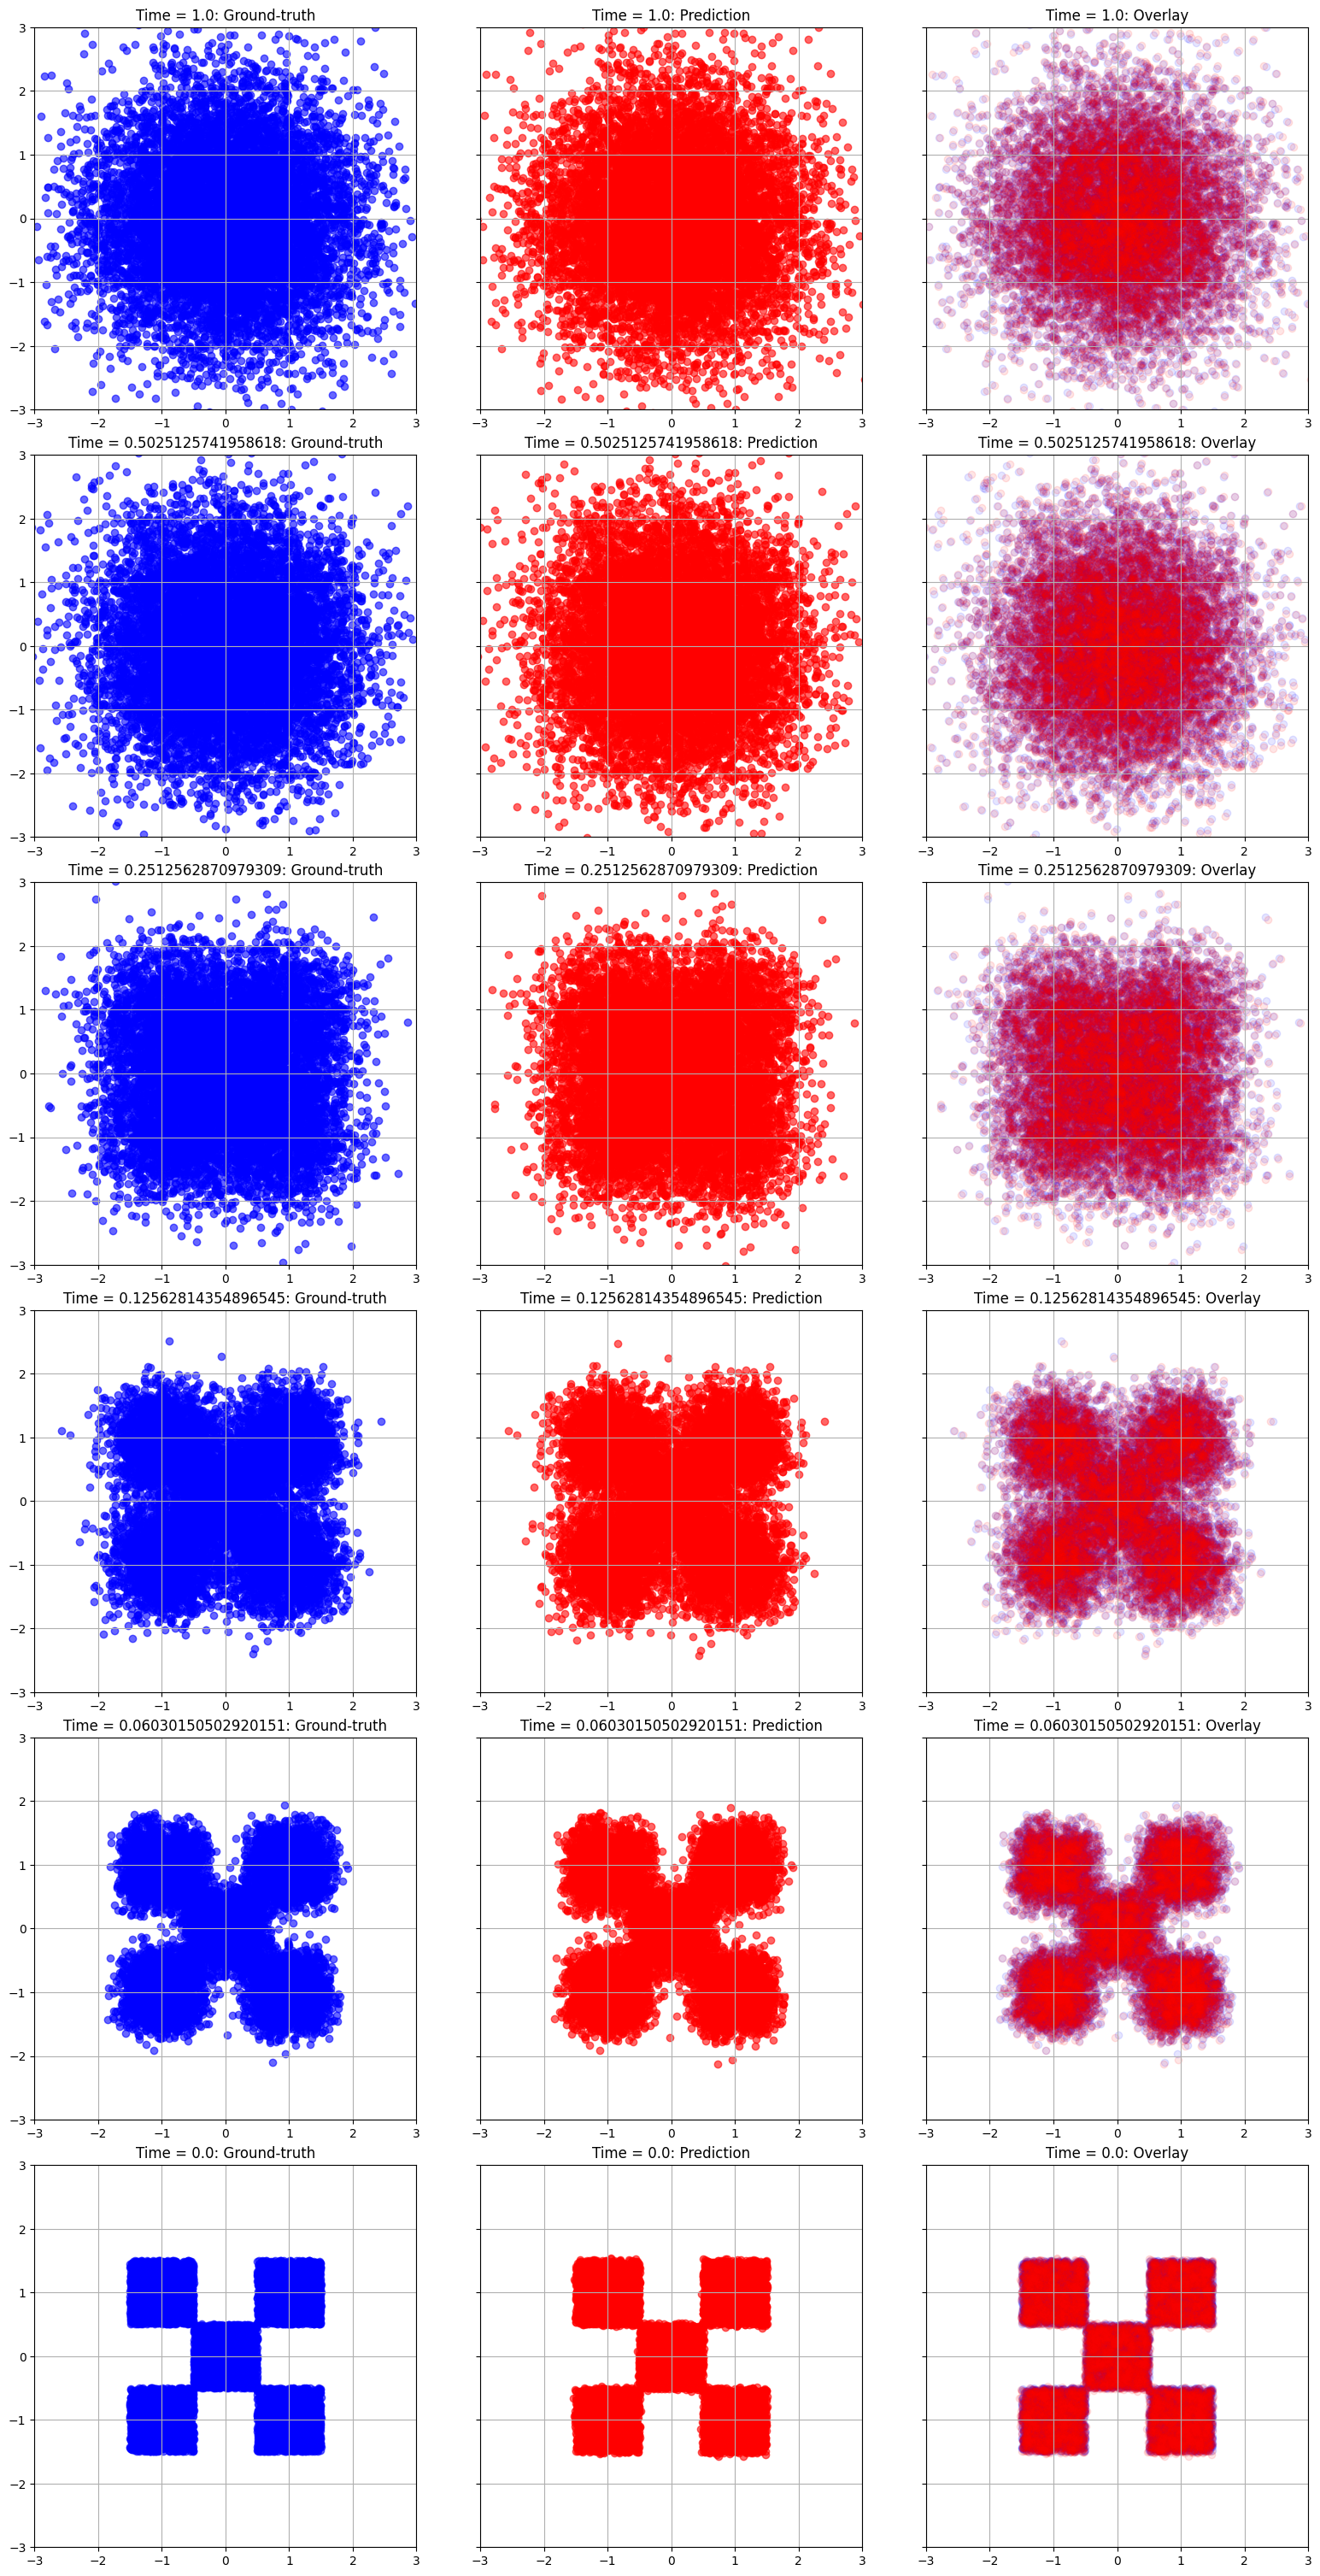

In [10]:

# Select timestamps to visualize
selected_timestamps = [0, T//16, T//8, T//4, T//2, T-1]
selected_times = [time_vector[t].item() for t in selected_timestamps]

# Plotting the ground-truth and predictions
# fig, axs = plt.subplots(len(selected_timestamps), 2, figsize=(24, 4 * len(selected_timestamps)), sharey=True)
fig, axs = plt.subplots(len(selected_timestamps), 3, figsize=(16, 5 * len(selected_timestamps)), sharey=True)

for j, t in enumerate(selected_timestamps):
    i = len(selected_times) - 1 - j
    # Actual dynamics
    axs[i, 0].scatter(y_test[:, 0, t].cpu().numpy(), y_test[:, 1, t].cpu().numpy(), color='blue', alpha=0.6)
    axs[i, 0].set_xlim(-3, 3)
    axs[i, 0].set_ylim(-3, 3)
    axs[i, 0].set_aspect('equal')
    axs[i, 0].set_title(f'Time = {selected_times[j]}: Ground-truth')
    axs[i, 0].grid(True)

    # Predicted dynamics
    axs[i, 1].scatter(predictions[:, 0, t].cpu().numpy(), predictions[:, 1, t].cpu().numpy(), color='red', alpha=0.6)
    axs[i, 1].set_xlim(-3, 3)
    axs[i, 1].set_ylim(-3, 3)
    axs[i, 1].set_aspect('equal')
    axs[i, 1].set_title(f'Time = {selected_times[j]}: Prediction')
    axs[i, 1].grid(True)

    # Overlay of Ground-truth and Prediction
    axs[i, 2].scatter(y_test[:, 0, t].cpu().numpy(), y_test[:, 1, t].cpu().numpy(), color='blue', alpha=0.1, label='Ground-truth')
    axs[i, 2].scatter(predictions[:, 0, t].cpu().numpy(), predictions[:, 1, t].cpu().numpy(), color='red', alpha=0.1, label='Prediction')
    axs[i, 2].set_xlim(-3, 3)
    axs[i, 2].set_ylim(-3, 3)
    axs[i, 2].set_aspect('equal')
    axs[i, 2].set_title(f'Time = {selected_times[j]}: Overlay')
    axs[i, 2].grid(True)

# plt.suptitle('Comparison of Ground-truth and Predicted Dynamics at Selected Timestamps')
plt.tight_layout(pad=0.2, w_pad=0.3, h_pad=0.5)  # Adjust padding here
plt.savefig("no_sde_marginal")
plt.show()

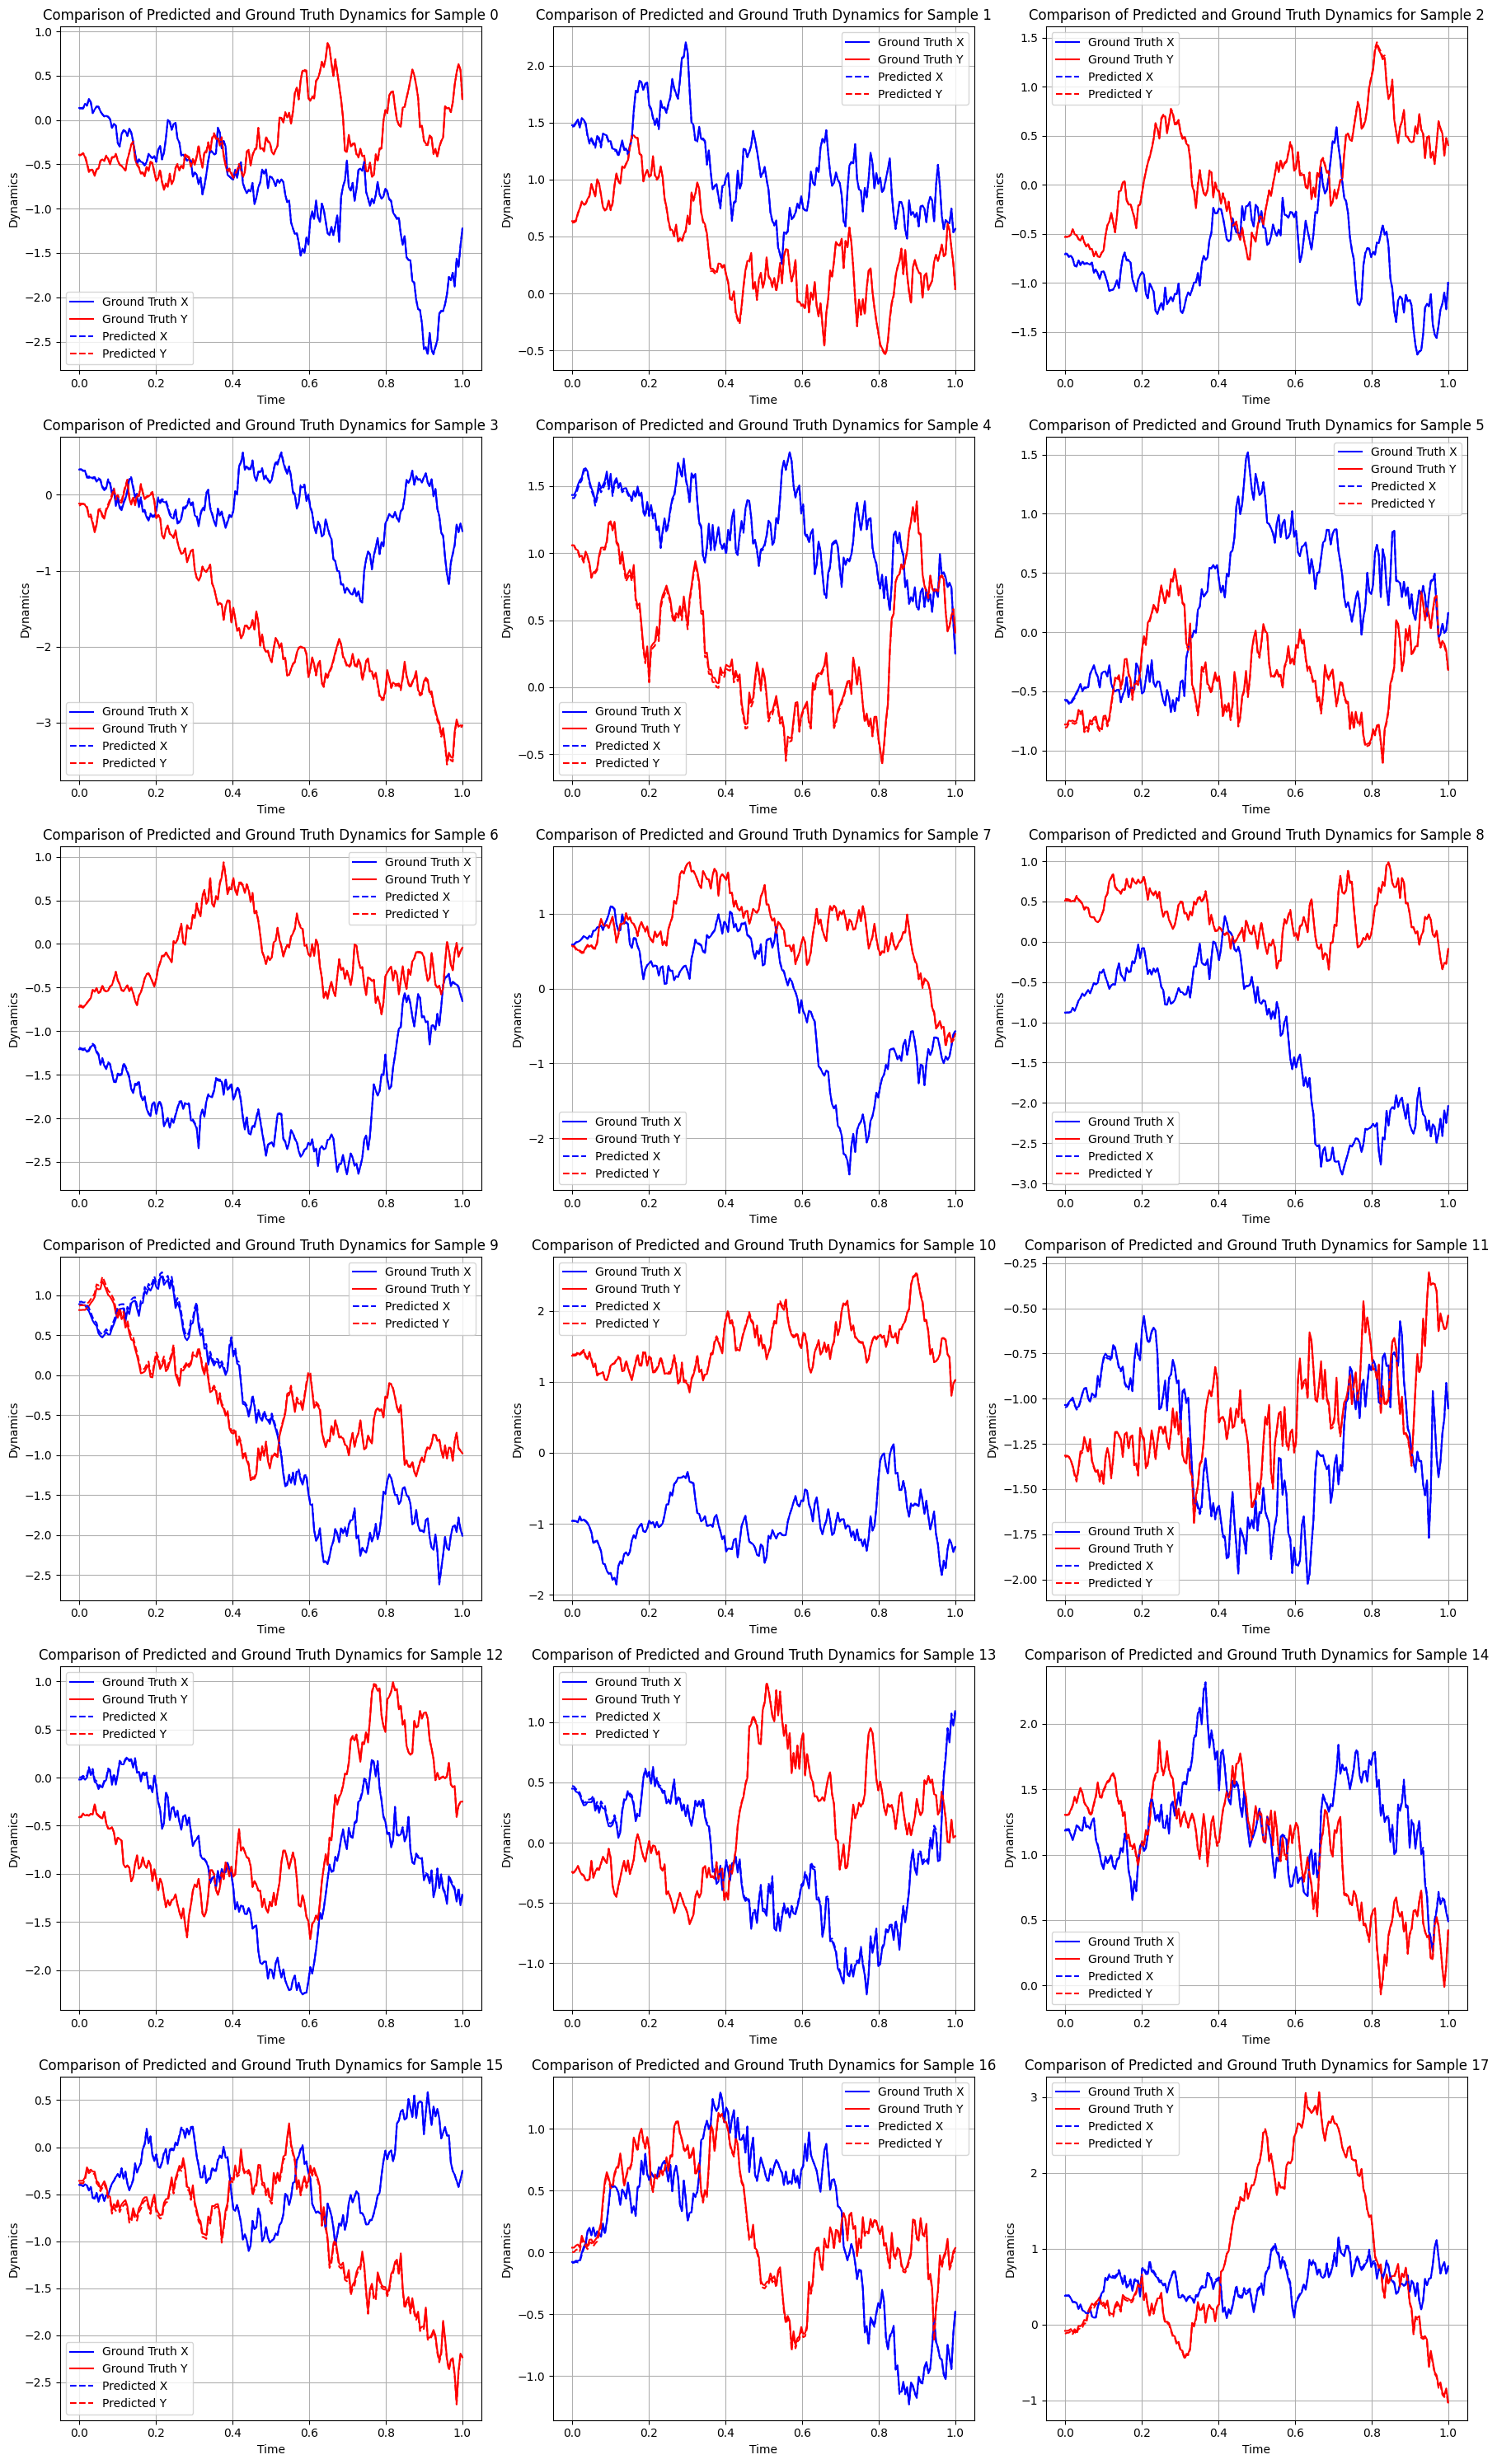

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `predictions` and `y_test` are tensors with dimensions [num_samples, 2, T]
# where `num_samples` is the total number of samples, `2` is for the X and Y coordinates, and `T` is the number of timesteps

# Sample indices to plot
sample_indices = [i for i in range(18)]  # You can modify this list to include any indices you're interested in

# Assuming `time_vector` is a tensor or array that corresponds to time steps, convert it to numpy array
time_steps = time_vector.numpy()  # Adjust this if time_vector is already a numpy array or needs different handling

# Set up the plot with 3 columns
num_columns = 3
num_rows = (len(sample_indices) + num_columns - 1) // num_columns  # Calculate the number of rows needed

plt.figure(figsize=(18, 5 * num_rows))  # Adjust the figure size appropriately

for i, sample_index in enumerate(sample_indices, start=1):
    # Extract the paths for predictions and ground truth for the current sample index
    sample_predictions = predictions[sample_index].cpu().numpy()  # Move data to CPU and convert to numpy if it's a tensor
    sample_ground_truth = y_test[sample_index].cpu().numpy()  # Move data to CPU and convert to numpy if it's a tensor
    
    # Create a subplot for each sample
    plt.subplot(num_rows, num_columns, i)
    plt.plot(time_steps, sample_ground_truth[0, :], label='Ground Truth X', color='blue')
    plt.plot(time_steps, sample_ground_truth[1, :], label='Ground Truth Y', color='red')
    plt.plot(time_steps, sample_predictions[0, :], label='Predicted X', linestyle='--', color='blue')
    plt.plot(time_steps, sample_predictions[1, :], label='Predicted Y', linestyle='--', color='red')

    plt.title(f'Comparison of Predicted and Ground Truth Dynamics for Sample {sample_index}')
    plt.xlabel('Time')
    plt.ylabel('Dynamics')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.savefig("no_sde_paths")
plt.show()
